# RC fitting strategy perf comparison (WheatFspm)

The following notebook analyzes and compares the results generated by `2022_04_06_optimizing_fitting_strategy.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
score_files = [
  # 'scores_LeaveOneOut.csv'
  'results.csv'
]

### Loading the experiment scores

In [3]:
data = None

for filename in score_files:
  df = pd.read_csv(filename, index_col=0)
  if data is None:
    data = df
  else:
    data = pd.concat((data, df))

targets = data['target'].unique().tolist()
state_vars = data['state_var'].unique().tolist()
datasets = data['dataset'].unique().tolist()

data = data.set_index(['target', 'state_var', 'dataset'])
data = data.sort_values(['target', 'state_var', 'dataset'], axis=0)

print(state_vars)

['state__An', 'state__Transpiration', 'state__S_Sucrose', 'state__Ts', 'state__gs', 'state__Ag', 'state__Tr', 'state__sucrose', 'state__Rd', 'state__sum_respi', 'state__Photosynthesis', 'state__PARa', 'env_res', 'env_temp_only']


### Comparing test score performance between strategies

Score distribution per strategy:

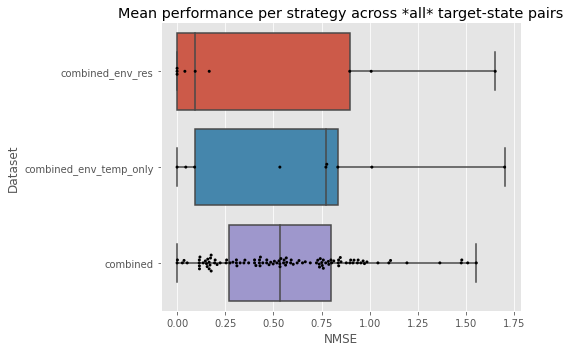

In [4]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, :, :].reset_index()
  plot_data['test_score'] *= -1

  # g = sns.catplot(y="dataset", x="test_score", kind="violin", orient='h', data=plot_data, height=5, aspect=1.5, inner=None)
  g = sns.catplot(y="dataset", x="test_score", kind="box", orient='h', data=plot_data, height=5, aspect=1.5)
  sns.swarmplot(y="dataset", x="test_score", color="k", size=3, data=plot_data, ax=g.ax)
  g.set(title='Mean performance per strategy across *all* target-state pairs', ylabel='Dataset', xlabel='NMSE') 
  g.tight_layout()
  plt.show()

Score distribution per strategy for increasing percentile

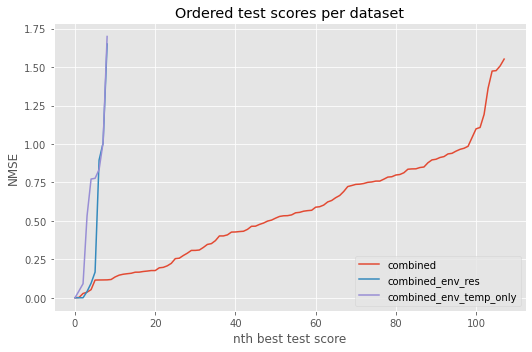

In [5]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(5*1.5, 5))
  
  for dataset in datasets:
    plot_data = data.loc[:, :, dataset, :].reset_index()
    plot_data = plot_data.sort_values(by='test_score', ascending=False)
    plot_data['test_score'] *= -1
    plot_data = plot_data.reset_index()
    plt.plot(plot_data.index, plot_data['test_score'], label=dataset)

  plt.legend()
  plt.ylabel('NMSE')
  plt.xlabel('nth best test score')
  plt.title('Ordered test scores per dataset')
  plt.tight_layout()
    

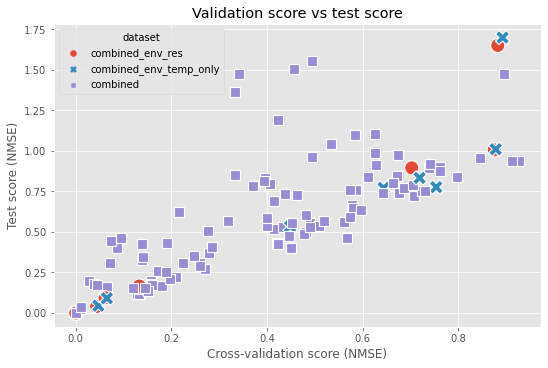

In [6]:
with plt.style.context('ggplot'):
  plot_data = data.loc[:, :, :, :].reset_index()
  plot_data['test_score'] *= -1
  plot_data['train_mean'] *= -1
  fig, ax = plt.subplots(1, 1, figsize=(1.5 * 5, 5), constrained_layout=True)
  sns.scatterplot(x='train_mean', y='test_score', hue='dataset', style='dataset', s=200, data=plot_data, ax=ax)
  ax.set_title('Validation score vs test score')
  ax.set_xlabel('Cross-validation score (NMSE)')
  ax.set_ylabel('Test score (NMSE)')

  # label outliers
  outlier_data = plot_data[plot_data['test_score'] > 5]

  def print_annotation(row):
    ax.text(row['train_mean'], row['test_score'], row['target'], rotation=0)

  outlier_data.apply(print_annotation, axis=1)

  plt.show()

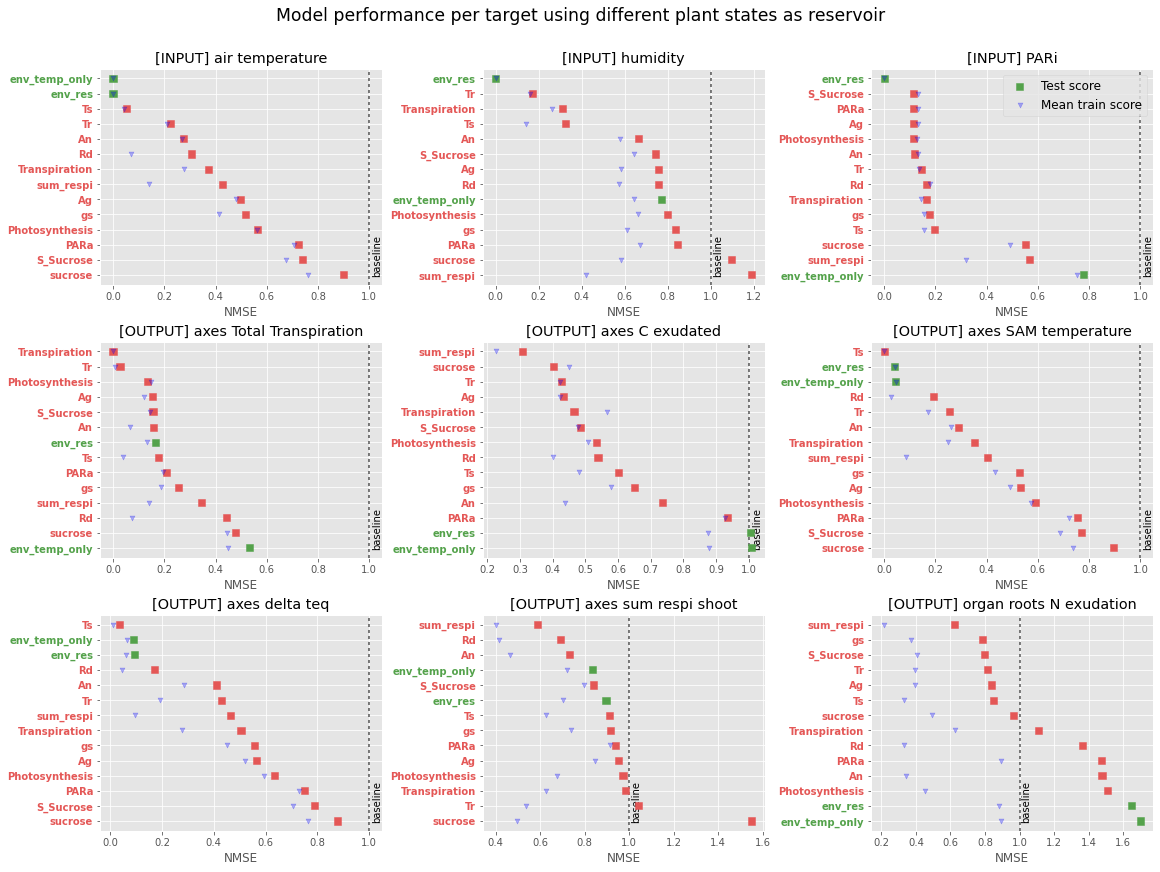

In [7]:
DO_NOT_PLOT = []


with plt.style.context('ggplot'):
  n_cols = 3
  n_rows = np.ceil(len(targets) / n_cols).astype(int)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 12), squeeze=False, sharey=False, constrained_layout=True)


  for target, ax in zip(targets, axs.flatten()):


    plot_data = data.loc[target, :, :].reset_index()
    plot_data = plot_data.sort_values(by='test_score', ascending=True)
    plot_data = plot_data.loc[~plot_data.index.isin(DO_NOT_PLOT)]
    
    x = np.arange(len(state_vars) - len(DO_NOT_PLOT))
    colors = ['#54A24B' if label.startswith('env') else '#E45756' for label in plot_data['state_var']]


    ax.axvline(1, dashes=(2, 2), color='black', alpha=0.66)
    ax.text(1.01, 0, 'baseline', fontsize='medium', rotation='vertical')
  
    ax.scatter(-plot_data['test_score'], x, label='Test score', color=colors, alpha=1, marker='s', s=50, zorder=10)
    ax.scatter(-plot_data['train_mean'], x, label='Mean train score', color='blue', alpha=0.3, marker='v', s=25, zorder=10)
    
    yticklabels = [label if label.startswith('env') else label[7:] for label in plot_data['state_var']]
    ax.set_yticks(np.arange(len(state_vars) - len(DO_NOT_PLOT)))
    ax.set_yticklabels(yticklabels, fontdict={'fontweight': 'demi'})
    ax.set_title(f'{target.replace("_", " ").replace("  ", " ").replace("input", "[INPUT]").replace("output", "[OUTPUT]")}')
    ax.set_xlabel('NMSE')
    if ax is axs[0][n_cols-1]:
      ax.legend(loc='upper right', fontsize='large')

    for ticklabel, tickcolor in zip(ax.get_yticklabels(), colors):
      ticklabel.set_color(tickcolor)

  for ax in axs.flatten()[len(targets):]:
    ax.remove()

  fig.suptitle(f'Model performance per target using different plant states as reservoir\n', size='xx-large')
  plt.show()